<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-model" data-toc-modified-id="Create-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create model</a></span><ul class="toc-item"><li><span><a href="#Helper-training-functions" data-toc-modified-id="Helper-training-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Helper training functions</a></span></li></ul></li><li><span><a href="#Start-Libvis" data-toc-modified-id="Start-Libvis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Start Libvis</a></span><ul class="toc-item"><li><span><a href="#Watch-updates" data-toc-modified-id="Watch-updates-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Watch updates</a></span></li><li><span><a href="#Configure-poll-delay" data-toc-modified-id="Configure-poll-delay-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Configure poll delay</a></span></li><li><span><a href="#Stop-app" data-toc-modified-id="Stop-app-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Stop app</a></span></li><li><span><a href="#Restart-app" data-toc-modified-id="Restart-app-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Restart app</a></span></li></ul></li><li><span><a href="#Initialize-pytorch-model-and-data" data-toc-modified-id="Initialize-pytorch-model-and-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initialize pytorch model and data</a></span></li><li><span><a href="#Configure-optimizer-to-use-live-learning-rate" data-toc-modified-id="Configure-optimizer-to-use-live-learning-rate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Configure optimizer to use live learning rate</a></span><ul class="toc-item"><li><span><a href="#Set-up-slider-for-learning-rate" data-toc-modified-id="Set-up-slider-for-learning-rate-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Set up slider for learning rate</a></span></li><li><span><a href="#How-this-works?" data-toc-modified-id="How-this-works?-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>How this works?</a></span></li></ul></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train the model</a></span></li><li><span><a href="#Button" data-toc-modified-id="Button-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Button</a></span></li><li><span><a href="#Custom-serializer:-watch-weights-live" data-toc-modified-id="Custom-serializer:-watch-weights-live-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Custom serializer: watch weights live</a></span></li></ul></div>

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from libvis import Vis

# Using libvis for live monitoring of pytorch training

## Create model

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### Helper training functions

We will need to put our loss function values somewhere. You can pass a list as an argument, but here let's just declare a global variable

In [ ]:
LOSSES = []

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        LOSSES.append(loss.item())
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Start Libvis

In [4]:
vis = Vis(ws_port=7700, vis_port=7000)
vis.configure_logging('WARNING')
print('Polling delay:', vis.app._watch_poll_delay)

Started libvis app at http://localhost:7000
Polling delay: 0.2


### Watch updates

To monitor a variable in background use the `vis.watch` method.
Libvis stores your object internally and sends it to visualization app every 0.2 seconds.

This method is usefull when you have large data that is frequently updated and you can miss some updates - 
like UDP internet protocol.

In [5]:
vis.watch(LOSSES, 'loss')

'Legi_0x7f865b2b2d10'

In [6]:
ph = 0
while True:
    ph+=1
    LOSSES[:] = np.sin((np.arange(100)+ph)/10)
    try:
        time.sleep(.2)
    except KeyboardInterrupt:
        print('Interrupted')
        break

Interrupted


In [13]:
LOSSES.clear()

### Configure poll delay

This delay determines how often variables that are watched sent to visualization app.

Even if the data was not changed, it will be serialized, sent to the app and re-rendered.
Sending them too often may result in high CPU usage. 
If you want real-time display, you should use direct updates

In [6]:
vis.app._watch_poll_delay  = 1

What happens if we loose the connection? The webapp will start listening for a new one and will reconect upon new connection.

### Stop app

You can stop the app by calling `vis.stop()`. It will stop both the http server for webapp and the websocket server. If you already have the app opened in browser, it will indicate that it lost connection.

In [7]:
vis.stop()

Stopping webapp http server: `Vis.stop_http()`... OK
Stopping websocket server: `Vis.app.stop()`... OK


### Restart app

To restart the same app, use `vis.start()`. The webapp will detect the new server and restore the connection.

In [8]:
vis.start()

Started libvis app at http://localhost:7000


## Initialize pytorch model and data

In [9]:
use_cuda = False

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

epochs=2
batch_size=3000
model = Net().to(device)

In [10]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

## Configure optimizer to use live learning rate

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

Now that we can read the data in realtime, let's enable live updates to optimizer's learning rate.


Integers in python are immutable, which means that we can't just share a value of `lr`
with libvis to apply updates from the webapp.

This means we have to have access to some mutable object, which stores the `lr` for optimizer. Such object is `optimizer.param_groups`.

In [12]:
optimizer.param_groups[0].keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad'])

### Set up slider for learning rate

Libvis is meant to be a library of visualisation widgets, or modules.
There are some pre-installed modules, like one used by default to represent a list.
That `LineGraph` built-in module has no python part - it's the built-in `list` type.

Let's use a `Slider` submodule from module `libvis.modules.uicontrols`.

In [13]:
from libvis.modules import uicontrols

In [15]:
lr = optimizer.param_groups[0]['lr']
slider = uicontrols.Slider(value=lr, min=0, max=0.05)
vis.vars.lr = slider

In [16]:
slider

{'on_change': <function print>,
 'min': 0,
 'max': 0.05,
 'value': 0.003,
 'type': 'slider'}

The slider has `on_change` attribute with function `print()` as a value. Let's change it to something useful.

In [17]:
def on_slider(lr_new):
    optimizer.param_groups[0]['lr'] = lr_new
    print('Changed lr to', lr_new)
    
vis.vars.lr.on_change = on_slider

Changed lr to 0.012
Changed lr to 0.0235


### How this works?

The `vis.vars` object is a `dict`, but a special one. First of all, you can assign keys to it
by assigning attributes. Second, each time an attribute assigned, the value
is sent to a websocket connected to `vis.vars`.

This special object is like a separate 'channel' for updates on some state.
_Libvis_ uses a separate library to sync states, called `legimens`, and `vis.vars` is `legimens.Object`.

Each module in _libvis_ is a `legimens.Object`.
To connect to an object client should specify a special token, called `ref`.
You can get this value by calling `legimens.Object.ref` on the object.

In [19]:
from legimens.Object import ref
ref(vis.vars.lr)

'Legi_0x7f8659953450'

Now, anyone who connects through a websocket to `localhost:7700/{ref(vis.vars.lr)}` will receive updates of the slider values and will be able to update the slider.
This is very useful when training on a remote server -
you can monitor your process from any internet-enabled device.

Try tihs one:

In [20]:
slider.value = 0.035

The value in your webapp should update to 0.035.
It will not call the `on_slider` function, since it is called only on updates from the websocket.

In [22]:
optimizer.param_groups[0]['lr']

0.0235

If you want to act as if you are updates from websocket, use `.vis_set(key, value)` method.
It also does conversion from string, since all updates are serialized to string values.

In [30]:
slider.vis_set('value',  0.001 )
slider.vis_set('value', '0.001')
optimizer.param_groups[0]['lr']

Changed lr to 0.001
Changed lr to 0.001


0.001

## Train the model

Now it's time to play with learning rate while training a model!

In [ ]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

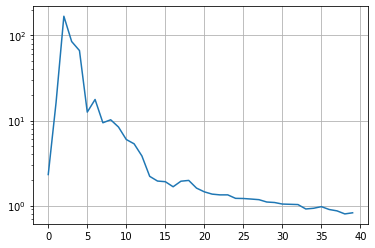

In [26]:
plt.plot(LOSSES)
plt.yscale('log')
plt.grid()

## Button

Let's look at another member of `libvis.modules.uicontrols` - `Button`.
It's pretty straightforward - you can call a function upon press of a button in app.

In [41]:
def increment_silder():
    print('Incrementing!')
    vis.vars.lr.vis_set('value', vis.vars.lr.value + 0.01)
    
vis.vars.button = uicontrols.Button(label='Press me!', on_press=increment_silder)


Changed lr to 0.0225
Incrementing!
Changed lr to 0.0325
Incrementing!
Changed lr to 0.0425


## Custom serializer: watch weights live

In [ ]:
from libvis import interface as ifc

def ser(x):
    return x.clone().cpu().detach().numpy().tolist()

ser(model.fc2.weight)

In [45]:
ifc.add_serializer(type(model.fc2.weight), ser)

In [57]:
vis.watch(model.fc2.weight, 'fc2')

'Legi_0x7f8648685e50'

Now, if you restart the training, you will be able to see the model weights update in real-time!
They don't change very much when the model is already trained, so you might want to 
make learning rate larger.

You can also re-create the model
and re-connect the variable.

And now you have a fully-interactive remote dashboard for your learning process!


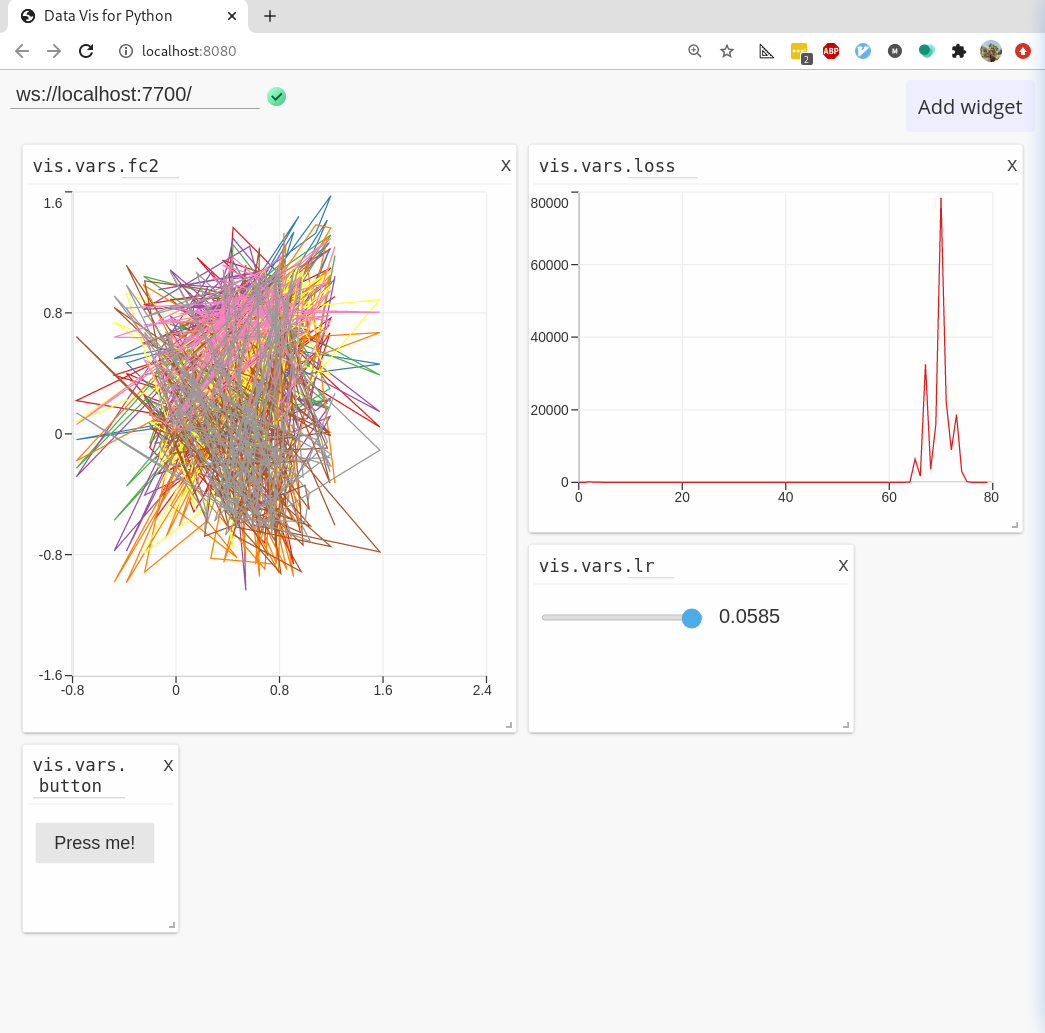

In [64]:
vis.stop()

Stopping webapp http server: `Vis.stop_http()`... OK
Stopping websocket server: `Vis.app.stop()`... OK
